In [2]:
import cython

In [3]:
print(cython.__version__)

3.0.11


In [4]:
%load_ext cython

In [16]:

from TidalPy.constants import G
import numpy as np
pi = np.pi
from numba import njit

@njit
def fundamental_matrix_generic(
    radius_array: np.ndarray, complex_shear_array: np.ndarray,
    density_array: np.ndarray, gravity_array: np.ndarray, order_l: int = 2
    ):
    """ Construct the fundamental matrix and its inverse for a generic order-l

    See Eq. 2.42 of SVC16

    Assumptions
    -----------
    - These matrices assume an incompressible body.

    Parameters
    ----------
    radius_array : np.ndarray
        Radius array of the planet [m]
    complex_shear_array : np.ndarray
        Complex Shear modulus at each radii [Pa]
    density_array : np.ndarray
        Density at each radii [kg m-3]
    gravity_array : np.ndarray
        Acceleration due to gravity at each radii [m s-2]
    order_l : int = 2
        Tidal Harmonic Degree Index

    Returns
    -------
    fundamental_matrix : np.ndarray
        Fundamental matrix used in the propagation technique
    fundamental_matrix_inverse : np.ndarray
        The inverse of the fundamental matrix used in the propagation technique
    derivative_mtx : np.ndarray
        The matrix, A, that satisfies the equation dy/dr = A * y

    """

    # First index: Rows of the propagation matrix
    # Second index: Columns of the propagation matrix
    # Third index: shell index (set outside of function)
    num_shells = radius_array.shape[0]
    fundamental_mtx = np.zeros((6, 6, num_shells), dtype=np.complex128)

    # Optimizations
    r_inv = 1. / radius_array
    rl = radius_array**order_l
    rlp1 = radius_array**(order_l + 1)
    rlp2 = radius_array**(order_l + 2)
    rlp3 = radius_array**(order_l + 3)
    rnl = radius_array**(-order_l)
    rnlm2 = radius_array**(-order_l - 2)
    rlm1 = radius_array**(order_l - 1)
    dlm1 = (2. * order_l - 1.)
    l2p3lm1 = (order_l**2 + 3. * order_l - 1.)
    l2mlm3 = (order_l**2 - order_l - 3.)
    lp1 = (order_l + 1.)
    lp2 = (order_l + 2.)
    lp3 = (order_l + 3.)
    l2m1 = (order_l**2 - 1.)
    dlp1 = (2. * order_l + 1.)
    dlp3 = (2. * order_l + 3.)

    rgp = radius_array * gravity_array * density_array
    rgp_s = rgp / complex_shear_array
    r_s = radius_array / complex_shear_array
    pr_s = density_array * r_s

    # Build Fundamental Matrix (zeros do not need to be specifically stated as they were put in at initialization)
    #     Eq. 2.42 in SVC
    ## Column 1
    fundamental_mtx[0, 0, :] = order_l * rlp1 / (2. * dlp3)
    fundamental_mtx[1, 0, :] = lp3 * rlp1 / (2. * dlp3 * lp1)
    fundamental_mtx[2, 0, :] = (order_l * rgp + 2. * l2mlm3 * complex_shear_array) * rl / (
                2. * dlp3)  # Believe there is a typo in HH14, they have the r^l only on one term instead of both.
    fundamental_mtx[3, 0, :] = order_l * lp2 * complex_shear_array * rl / (dlp3 * lp1)
    # fundamental_mtx[4, 0, :] = np.zeros(num_shells)
    fundamental_mtx[5, 0, :] = 2. * pi * G * density_array * order_l * rlp1 / dlp3

    ## Column 2
    fundamental_mtx[0, 1, :] = rlm1
    fundamental_mtx[1, 1, :] = rlm1 / order_l
    fundamental_mtx[2, 1, :] = (rgp + 2. * (order_l - 1.) * complex_shear_array) * radius_array**(order_l - 2.)
    fundamental_mtx[3, 1, :] = 2 * (order_l - 1.) * complex_shear_array * radius_array**(order_l - 2.) / order_l
    # fundamental_mtx[4, 1, :] = np.zeros(num_shells)
    fundamental_mtx[5, 1, :] = 4. * pi * G * density_array * rlm1

    ## Column 3
    # fundamental_mtx[0, 2, :] = np.zeros(num_shells)
    # fundamental_mtx[1, 2, :] = np.zeros(num_shells)
    fundamental_mtx[2, 2, :] = -density_array * rl
    # fundamental_mtx[3, 2, :] = np.zeros(num_shells)
    fundamental_mtx[4, 2, :] = -rl
    fundamental_mtx[5, 2, :] = -dlp1 * rlm1

    ## Column 4
    fundamental_mtx[0, 3, :] = lp1 * rnl / (2. * dlm1)
    fundamental_mtx[1, 3, :] = (2. - order_l) * rnl / (2. * order_l * dlm1)
    fundamental_mtx[2, 3, :] = (lp1 * rgp - 2. * l2p3lm1 * complex_shear_array) / (2. * dlm1 * rlp1)
    fundamental_mtx[3, 3, :] = l2m1 * complex_shear_array / (order_l * dlm1 * rlp1)
    # fundamental_mtx[4, 3, :] = np.zeros(num_shells)
    fundamental_mtx[5, 3, :] = 2 * pi * G * density_array * lp1 / (dlm1 * rl)

    ## Column 5
    fundamental_mtx[0, 4, :] = rnlm2
    fundamental_mtx[1, 4, :] = -rnlm2 / lp1
    fundamental_mtx[2, 4, :] = (rgp - 2. * lp2 * complex_shear_array) / rlp3
    fundamental_mtx[3, 4, :] = 2. * lp2 * complex_shear_array / (lp1 * rlp3)
    # fundamental_mtx[4, 4, :] = np.zeros(num_shells)
    fundamental_mtx[5, 4, :] = 4. * pi * G * density_array / rlp2

    ## Column 6
    # fundamental_mtx[0, 5, :] = np.zeros(num_shells)
    # fundamental_mtx[1, 5, :] = np.zeros(num_shells)
    fundamental_mtx[2, 5, :] = -density_array / rlp1
    # fundamental_mtx[3, 5, :] = np.zeros(num_shells)
    fundamental_mtx[4, 5, :] = -1. / rlp1
    # fundamental_mtx[5, 5, :] = np.zeros(num_shells)

    # Inverse of the Fundamental Matrix
    # This function manually defines the inverse matrix which is about 15--30% faster than a version that uses
    #    np.linalg.inv() to calculate the inverse matrix.
    #
    # From SVC16 Eq. 2.45: Fundamental Inverse = D_Mtx * Y^Bar_Mtx
    # D_Mtx is a diagonal matrix with
    # 1/(2l+1) * [ ... ]
    # We are going to multiple first and just write down the fundamental matrix inverse to avoid the additional D*Ybar
    #    calculation.
    inverse_fundamental_mtx = np.zeros((6, 6, num_shells), dtype=np.complex128)

    # D Coefficients
    coeff = (1. / dlp1)
    d_coeff_1 = coeff * lp1 / rlp1
    d_coeff_2 = coeff * order_l * lp1 / (2. * dlm1 * rlm1)
    d_coeff_3 = coeff * 1. / rlm1
    d_coeff_4 = coeff * order_l * rl
    d_coeff_5 = coeff * rlp2 * order_l * lp1 / (2. * dlp3)
    d_coeff_6 = coeff * -rlp1

    ## Column 1
    inverse_fundamental_mtx[0, 0, :] = d_coeff_1 * (rgp_s - 2. * lp2)
    inverse_fundamental_mtx[1, 0, :] = d_coeff_2 * (-rgp_s + 2. * l2p3lm1 / lp1)
    inverse_fundamental_mtx[2, 0, :] = d_coeff_3 * (4. * pi * G * density_array)
    inverse_fundamental_mtx[3, 0, :] = d_coeff_4 * (rgp_s + 2. * (order_l - 1.))
    inverse_fundamental_mtx[4, 0, :] = d_coeff_5 * (-rgp_s - 2. * l2mlm3 / order_l)
    inverse_fundamental_mtx[5, 0, :] = d_coeff_6 * (4. * pi * G * density_array * radius_array)

    ## Column 2
    inverse_fundamental_mtx[0, 1, :] = d_coeff_1 * (2. * order_l * lp2)
    inverse_fundamental_mtx[1, 1, :] = d_coeff_2 * (-2. * l2m1)
    # inverse_fundamental_mtx[2, 1, :] = np.zeros(num_shells)
    inverse_fundamental_mtx[3, 1, :] = d_coeff_4 * (2. * l2m1)
    inverse_fundamental_mtx[4, 1, :] = d_coeff_5 * (-2. * order_l * lp2)
    # inverse_fundamental_mtx[5, 1, :] = np.zeros(num_shells)

    ## Column 3
    inverse_fundamental_mtx[0, 2, :] = d_coeff_1 * (-r_s)
    inverse_fundamental_mtx[1, 2, :] = d_coeff_2 * (r_s)
    # inverse_fundamental_mtx[2, 2, :] = np.zeros(num_shells)
    inverse_fundamental_mtx[3, 2, :] = d_coeff_4 * (-r_s)
    inverse_fundamental_mtx[4, 2, :] = d_coeff_5 * (r_s)
    # inverse_fundamental_mtx[5, 2, :] = np.zeros(num_shells)

    ## Column 4
    inverse_fundamental_mtx[0, 3, :] = d_coeff_1 * (order_l * r_s)
    inverse_fundamental_mtx[1, 3, :] = d_coeff_2 * ((2. - order_l) * r_s)
    # inverse_fundamental_mtx[2, 3, :] = np.zeros(num_shells)
    inverse_fundamental_mtx[3, 3, :] = d_coeff_4 * (-lp1 * r_s)
    inverse_fundamental_mtx[4, 3, :] = d_coeff_5 * (lp3 * r_s)
    # inverse_fundamental_mtx[5, 3, :] = np.zeros(num_shells)

    ## Column 5
    inverse_fundamental_mtx[0, 4, :] = d_coeff_1 * (pr_s)
    inverse_fundamental_mtx[1, 4, :] = d_coeff_2 * (-pr_s)
    # inverse_fundamental_mtx[2, 4, :] = np.zeros(num_shells)
    inverse_fundamental_mtx[3, 4, :] = d_coeff_4 * (pr_s)
    inverse_fundamental_mtx[4, 4, :] = d_coeff_5 * (-pr_s)
    inverse_fundamental_mtx[5, 4, :] = d_coeff_6 * dlp1

    ## Column 6
    # inverse_fundamental_mtx[0, 5, :] = np.zeros(num_shells)
    # inverse_fundamental_mtx[1, 5, :] = np.zeros(num_shells)
    inverse_fundamental_mtx[2, 5, :] = d_coeff_3 * (-np.ones(num_shells, dtype=np.complex128))
    # inverse_fundamental_mtx[3, 5, :] = np.zeros(num_shells)
    # inverse_fundamental_mtx[4, 5, :] = np.zeros(num_shells)
    inverse_fundamental_mtx[5, 5, :] = d_coeff_6 * (-radius_array)

    # Build derivative matrix
    # Defined in SV04 -- Only valid for the incompressible case.
    # See SVC16 Eq. 1.95
    #    Note: the lambda in SVC16 is defined as bulk_mod - (2. / 3.) * shear (Eq. 1.77; 2nd Lame parameter),
    #    for the incompressible assumption we will assume the ratio that SVC16 use (lambda / beta) -> 1 as K -> inf
    #    See SVC16 Eq. 1.95 for a compressible version. Take limit as K->inf to find below.
    derivative_mtx = np.zeros((6, 6, num_shells), dtype=np.complex128)
    ## Column 1
    derivative_mtx[0, 0, :] = -2. * r_inv
    derivative_mtx[1, 0, :] = -1. * r_inv
    derivative_mtx[2, 0, :] = (4. * r_inv) * (3. * complex_shear_array * r_inv - density_array * gravity_array)
    derivative_mtx[3, 0, :] = (-1. * r_inv) * (6. * complex_shear_array * r_inv - density_array * gravity_array)
    derivative_mtx[4, 0, :] = -4. * np.pi * G * density_array
    derivative_mtx[5, 0, :] = -4. * np.pi * G * density_array * (order_l + 1) * r_inv

    ## Column 2
    derivative_mtx[0, 1, :] = order_l * lp1 * r_inv
    derivative_mtx[1, 1, :] = r_inv
    derivative_mtx[2, 1, :] = -order_l * lp1 * r_inv * (6. * complex_shear_array * r_inv -
                                                        density_array * gravity_array)
    derivative_mtx[3, 1, :] = 2. * (2. * order_l**2 + 2. * order_l - 1.) * complex_shear_array * (r_inv**2)
    # derivative_mtx[4, 1, :] = np.zeros(num_shells)
    derivative_mtx[5, 1, :] = 4. * np.pi * G * density_array * order_l * lp1 * r_inv

    ## Column 3
    # derivative_mtx[0, 2, :] = np.zeros(num_shells)
    # derivative_mtx[1, 2, :] = np.zeros(num_shells)
    # derivative_mtx[2, 2, :] = np.zeros(num_shells)
    derivative_mtx[3, 2, :] = -r_inv
    # derivative_mtx[4, 2, :] = np.zeros(num_shells)
    # derivative_mtx[5, 2, :] = np.zeros(num_shells)

    ## Column 4
    # derivative_mtx[0, 3, :] = np.zeros(num_shells)
    derivative_mtx[1, 3, :] = 1. / complex_shear_array
    derivative_mtx[2, 3, :] = order_l * lp1 * r_inv
    derivative_mtx[3, 3, :] = -3. * r_inv
    # derivative_mtx[4, 3, :]= np.zeros(num_shells)
    # derivative_mtx[5, 3, :] = np.zeros(num_shells)

    ## Column 5
    # derivative_mtx[0, 4, :] = np.zeros(num_shells)
    # derivative_mtx[1, 4, :] = np.zeros(num_shells)
    derivative_mtx[2, 4, :] = -density_array * lp1 * r_inv
    derivative_mtx[3, 4, :] = density_array * r_inv
    derivative_mtx[4, 4, :] = -lp1 * r_inv
    # derivative_mtx[5, 4, :] = np.zeros(num_shells)

    ## Column 6
    # derivative_mtx[0, 5, :] = np.zeros(num_shells)
    # derivative_mtx[1, 5, :] = np.zeros(num_shells)
    derivative_mtx[2, 5, :] = density_array
    # derivative_mtx[3, 5, :] = np.zeros(num_shells)
    derivative_mtx[4, 5, :] = np.ones(num_shells, dtype=np.complex128)
    derivative_mtx[5, 5, :] = (order_l - 1.) * r_inv

    return fundamental_mtx, inverse_fundamental_mtx, derivative_mtx

In [17]:
%%cython -f -a
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libc.math cimport pi
from libcpp cimport bool as cpp_bool

from cython.parallel cimport prange

import numpy as np
cimport numpy as cnp
cnp.import_array()

from TidalPy.constants cimport d_G
from TidalPy.utilities.math.complex cimport cf_cinv


cdef void cf_fundamental_matrix(
        Py_ssize_t first_slice_index,
        Py_ssize_t num_radial_slices,
        double* radius_array_ptr,
        double* density_array_ptr,
        double* gravity_array_ptr,
        double complex* complex_shear_array_ptr,
        double complex* fundamental_mtx_ptr,
        double complex* inverse_fundamental_mtx_ptr,
        double complex* derivative_mtx_ptr,
        int degree_l = 2,
        double G_to_use = d_G
        ) noexcept nogil:
    """ Construct the fundamental matrix and its inverse for a generic order-l

    See Eq. 2.42 of SVC16

    Assumptions
    -----------
    - These matrices assume an incompressible body.

    Parameters
    ----------
    first_slice_index : Py_ssize_t
        Initial radial index to start populating matrices at.
    num_radial_slices : Py_ssize_t
        Number of radial slices
    radius_array_ptr : double
        Pointer to array of Radius values [m]
    density_array_ptr : double
        Pointer to array of Density at each radius [kg m-3]
    gravity_array_ptr : double
        Pointer to array_ptr of acceleration due to gravity at each radius [m s-2]
    complex_shear_array : double complex
        Pointer to array of Complex shear modulus at each radius [Pa]
    fundamental_mtx_ptr : double complex*
        _Return Value_
        6 x 6 matrix of double complex values
        Fundamental matrix used in the propagation technique
    inverse_fundamental_mtx_ptr : double complex*
        _Return Value_
        The inverse of the fundamental matrix used in the propagation technique
    derivative_mtx_ptr : double complex*
        _Return Value_
        The matrix, A, that satisfies the equation dy/dr = A * y
    degree_l : unsigned char, default=2
        Harmonic degree.
    G_to_use : double, default=d_G
        Gravitational constant used in calculations. Can be provided for non-dimensionalized solutions.
    """

    cdef Py_ssize_t slice_i, index_shift
    
    cdef double radius, gravity, density
    cdef double complex complex_shear
    
    cdef double r_inv, rl, rlp1, rlp2, rlp3, rnl, rnlm2, rlm1, rgp, piGp
    cdef double coeff, d_coeff_1, d_coeff_2, d_coeff_3, d_coeff_4, d_coeff_5, d_coeff_6
    cdef double complex mu_inv, rgp_s, r_s, pr_s

    # Degree-l Optimizations
    cdef double degree_l_dbl = <double> degree_l
    cdef double dlm1         = (2. * degree_l_dbl - 1.)
    cdef double l2p3lm1      = (degree_l_dbl**2 + 3. * degree_l_dbl - 1.)
    cdef double l2mlm3       = (degree_l_dbl**2 - degree_l_dbl - 3.)
    cdef double lp1          = (degree_l_dbl + 1.)
    cdef double lp2          = (degree_l_dbl + 2.)
    cdef double lp3          = (degree_l_dbl + 3.)
    cdef double l2m1         = (degree_l_dbl**2 - 1.)
    cdef double dlp1         = (2. * degree_l_dbl + 1.)
    cdef double dlp3         = (2. * degree_l_dbl + 3.)

    for slice_i in prange(first_slice_index, num_radial_slices):

        # Shift index by 36 (for the inner 6x6 matrix)
        index_shift = slice_i * 36

        # Unpack radially dependent variables
        radius        = radius_array_ptr[slice_i]
        complex_shear = complex_shear_array_ptr[slice_i]
        gravity       = gravity_array_ptr[slice_i]
        density       = density_array_ptr[slice_i]

        # Radius-based optimizations
        r_inv  = 1. / radius
        mu_inv = cf_cinv(complex_shear)
        rl     = radius**degree_l
        rlp1   = radius**(degree_l + 1)
        rlp2   = radius**(degree_l + 2)
        rlp3   = radius**(degree_l + 3)
        rnl    = radius**(-degree_l)
        rnlm2  = radius**(-degree_l - 2)
        rlm1   = radius**(degree_l - 1)
        rgp    = radius * gravity * density
        rgp_s  = rgp * mu_inv
        r_s    = radius * mu_inv
        pr_s   = density * r_s
        piGp   = pi * G_to_use * density
        
        # D Coefficients
        coeff = (1. / dlp1)
        d_coeff_1 = coeff * lp1 / rlp1
        d_coeff_2 = coeff * degree_l_dbl * lp1 / (2. * dlm1 * rlm1)
        d_coeff_3 = coeff * 1. / rlm1
        d_coeff_4 = coeff * degree_l_dbl * rl
        d_coeff_5 = coeff * rlp2 * degree_l_dbl * lp1 / (2. * dlp3)
        d_coeff_6 = coeff * -rlp1

        
        # Build Fundamental Matrix (zeros do not need to be specifically stated as they were put in at initialization)
        #     Eq. 2.42 in SVC
        ## Row 1
        fundamental_mtx_ptr[index_shift + 0]  = degree_l_dbl * rlp1 / (2. * dlp3)
        fundamental_mtx_ptr[index_shift + 1]  = rlm1
        fundamental_mtx_ptr[index_shift + 2]  = 0.
        fundamental_mtx_ptr[index_shift + 3]  = lp1 * rnl / (2. * dlm1)
        fundamental_mtx_ptr[index_shift + 4]  = rnlm2
        fundamental_mtx_ptr[index_shift + 5]  = 0.

        ## Row 2
        fundamental_mtx_ptr[index_shift + 6]  = lp3 * rlp1 / (2. * dlp3 * lp1)
        fundamental_mtx_ptr[index_shift + 7]  = rlm1 / degree_l_dbl
        fundamental_mtx_ptr[index_shift + 8]  = 0.
        fundamental_mtx_ptr[index_shift + 9]  = (2. - degree_l_dbl) * rnl / (2. * degree_l_dbl * dlm1)
        fundamental_mtx_ptr[index_shift + 10] = -rnlm2 / lp1
        fundamental_mtx_ptr[index_shift + 11] = 0.

        ## Row 3
        # RECORD: Believe there is a typo in HH14, they have the radius^l only on one term instead of both.
        fundamental_mtx_ptr[index_shift + 12] = (degree_l_dbl * rgp + 2. * l2mlm3 * complex_shear) * rl / (2. * dlp3)
        fundamental_mtx_ptr[index_shift + 13] = (rgp + 2. * (degree_l_dbl - 1.) * complex_shear) * radius**(degree_l_dbl - 2.)
        fundamental_mtx_ptr[index_shift + 14] = -density * rl
        fundamental_mtx_ptr[index_shift + 15] = (lp1 * rgp - 2. * l2p3lm1 * complex_shear) / (2. * dlm1 * rlp1)
        fundamental_mtx_ptr[index_shift + 16] = (rgp - 2. * lp2 * complex_shear) / rlp3
        fundamental_mtx_ptr[index_shift + 17] = -density / rlp1

        ## Row 4
        fundamental_mtx_ptr[index_shift + 18] = degree_l_dbl * lp2 * complex_shear * rl / (dlp3 * lp1)
        fundamental_mtx_ptr[index_shift + 19] = 2 * (degree_l_dbl - 1.) * complex_shear * radius**(degree_l_dbl - 2.) / degree_l_dbl
        fundamental_mtx_ptr[index_shift + 20] = 0.
        fundamental_mtx_ptr[index_shift + 21] = l2m1 * complex_shear / (degree_l_dbl * dlm1 * rlp1)
        fundamental_mtx_ptr[index_shift + 22] = 2. * lp2 * complex_shear / (lp1 * rlp3)
        fundamental_mtx_ptr[index_shift + 23] = 0.

        ## Row 5
        fundamental_mtx_ptr[index_shift + 24] = 0.
        fundamental_mtx_ptr[index_shift + 25] = 0.
        fundamental_mtx_ptr[index_shift + 26] = -rl
        fundamental_mtx_ptr[index_shift + 27] = 0.
        fundamental_mtx_ptr[index_shift + 28] = 0.
        fundamental_mtx_ptr[index_shift + 29] = -1. / rlp1

        ## Row 6
        fundamental_mtx_ptr[index_shift + 30] = 2. * piGp * degree_l_dbl * rlp1 / dlp3
        fundamental_mtx_ptr[index_shift + 31] = 4. * piGp * rlm1
        fundamental_mtx_ptr[index_shift + 32] = -dlp1 * rlm1
        fundamental_mtx_ptr[index_shift + 33] = 2 * piGp * lp1 / (dlm1 * rl)
        fundamental_mtx_ptr[index_shift + 34] = 4. * piGp / rlp2
        fundamental_mtx_ptr[index_shift + 35] = 0.

        # Inverse of the Fundamental Matrix
        # This function manually defines the inverse matrix which is about 15--30% faster than a version that uses
        #    np.linalg.inv() to calculate the inverse matrix.
        #
        # From SVC16 Eq. 2.45: Fundamental Inverse = D_Mtx * Y^Bar_Mtx
        # D_Mtx is a diagonal matrix with
        # 1/(2l+1) * [ ... ]
        # We are going to multiple first and just write down the fundamental matrix inverse to avoid the additional D*Ybar
        #    calculation.

        ## Row 1
        inverse_fundamental_mtx_ptr[index_shift + 0]  = d_coeff_1 * (rgp_s - 2. * lp2)
        inverse_fundamental_mtx_ptr[index_shift + 1]  = d_coeff_1 * (2. * degree_l_dbl * lp2)
        inverse_fundamental_mtx_ptr[index_shift + 2]  = d_coeff_1 * (-r_s)
        inverse_fundamental_mtx_ptr[index_shift + 3]  = d_coeff_1 * (degree_l_dbl * r_s)
        inverse_fundamental_mtx_ptr[index_shift + 4]  = d_coeff_1 * (pr_s)
        inverse_fundamental_mtx_ptr[index_shift + 5]  = 0.

        ## Row 2
        inverse_fundamental_mtx_ptr[index_shift + 6]  = d_coeff_2 * (-rgp_s + 2. * l2p3lm1 / lp1)
        inverse_fundamental_mtx_ptr[index_shift + 7]  = d_coeff_2 * (-2. * l2m1)
        inverse_fundamental_mtx_ptr[index_shift + 8]  = d_coeff_2 * (r_s)
        inverse_fundamental_mtx_ptr[index_shift + 9]  = d_coeff_2 * ((2. - degree_l_dbl) * r_s)
        inverse_fundamental_mtx_ptr[index_shift + 10] = d_coeff_2 * (-pr_s)
        inverse_fundamental_mtx_ptr[index_shift + 11] = 0.

        ## Row 3
        inverse_fundamental_mtx_ptr[index_shift + 12] = d_coeff_3 * (4. * piGp)
        inverse_fundamental_mtx_ptr[index_shift + 13] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 14] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 15] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 16] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 17] = -d_coeff_3

        ## Row 4
        inverse_fundamental_mtx_ptr[index_shift + 18] = d_coeff_4 * (rgp_s + 2. * (degree_l_dbl - 1.))
        inverse_fundamental_mtx_ptr[index_shift + 19] = d_coeff_4 * (2. * l2m1)
        inverse_fundamental_mtx_ptr[index_shift + 20] = d_coeff_4 * (-r_s)
        inverse_fundamental_mtx_ptr[index_shift + 21] = d_coeff_4 * (-lp1 * r_s)
        inverse_fundamental_mtx_ptr[index_shift + 22] = d_coeff_4 * (pr_s)
        inverse_fundamental_mtx_ptr[index_shift + 23] = 0.

        ## Row 5
        inverse_fundamental_mtx_ptr[index_shift + 24] = d_coeff_5 * (-rgp_s - 2. * l2mlm3 / degree_l_dbl)
        inverse_fundamental_mtx_ptr[index_shift + 25] = d_coeff_5 * (-2. * degree_l_dbl * lp2)
        inverse_fundamental_mtx_ptr[index_shift + 26] = d_coeff_5 * (r_s)
        inverse_fundamental_mtx_ptr[index_shift + 27] = d_coeff_5 * (lp3 * r_s)
        inverse_fundamental_mtx_ptr[index_shift + 28] = d_coeff_5 * (-pr_s)
        inverse_fundamental_mtx_ptr[index_shift + 29] = 0.

        ## Row 6
        inverse_fundamental_mtx_ptr[index_shift + 30] = d_coeff_6 * (4. * piGp * radius)
        inverse_fundamental_mtx_ptr[index_shift + 31] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 32] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 33] = 0.
        inverse_fundamental_mtx_ptr[index_shift + 34] = d_coeff_6 * dlp1
        inverse_fundamental_mtx_ptr[index_shift + 35] = d_coeff_6 * (-radius)

        # Build derivative matrix
        # Defined in SV04 -- Only valid for the incompressible case.
        # See SVC16 Eq. 1.95
        #    Note: the lambda in SVC16 is defined as bulk_mod - (2. / 3.) * shear (Eq. 1.77; 2nd Lame parameter),
        #    for the incompressible assumption we will assume the ratio that SVC16 use (lambda / beta) -> 1 as K -> inf
        #    See SVC16 Eq. 1.95 for a compressible version. Take limit as K->inf to find below.
        ## Row 1
        derivative_mtx_ptr[index_shift + 0]  = -2. * r_inv
        derivative_mtx_ptr[index_shift + 1]  = degree_l_dbl * lp1 * r_inv
        derivative_mtx_ptr[index_shift + 2]  = 0.
        derivative_mtx_ptr[index_shift + 3]  = 0.
        derivative_mtx_ptr[index_shift + 4]  = 0.
        derivative_mtx_ptr[index_shift + 5]  = 0.

        ## Row 2
        derivative_mtx_ptr[index_shift + 6]  = -1. * r_inv
        derivative_mtx_ptr[index_shift + 7]  = r_inv
        derivative_mtx_ptr[index_shift + 8]  = 0.
        derivative_mtx_ptr[index_shift + 9]  = mu_inv
        derivative_mtx_ptr[index_shift + 10] = 0.
        derivative_mtx_ptr[index_shift + 11] = 0.

        ## Row 3
        derivative_mtx_ptr[index_shift + 12] = (4. * r_inv) * (3. * complex_shear * r_inv - density * gravity)
        derivative_mtx_ptr[index_shift + 13] = -degree_l_dbl * lp1 * r_inv * (6. * complex_shear * r_inv - density * gravity)
        derivative_mtx_ptr[index_shift + 14] = 0.
        derivative_mtx_ptr[index_shift + 15] = degree_l_dbl * lp1 * r_inv
        derivative_mtx_ptr[index_shift + 16] = -density * lp1 * r_inv
        derivative_mtx_ptr[index_shift + 17] = density

        ## Row 4
        derivative_mtx_ptr[index_shift + 18] = (-1. * r_inv) * (6. * complex_shear * r_inv - density * gravity)
        derivative_mtx_ptr[index_shift + 19] = 2. * (2. * degree_l_dbl**2 + 2. * degree_l_dbl - 1.) * complex_shear * (r_inv**2)
        derivative_mtx_ptr[index_shift + 20] = -r_inv
        derivative_mtx_ptr[index_shift + 21] = -3. * r_inv
        derivative_mtx_ptr[index_shift + 22] = density * r_inv
        derivative_mtx_ptr[index_shift + 23] = 0.

        ## Row 5
        derivative_mtx_ptr[index_shift + 24] = -4. * piGp
        derivative_mtx_ptr[index_shift + 25] = 0.
        derivative_mtx_ptr[index_shift + 26] = 0.
        derivative_mtx_ptr[index_shift + 27] = 0.
        derivative_mtx_ptr[index_shift + 28] = -lp1 * r_inv
        derivative_mtx_ptr[index_shift + 29] = 1.

        ## Row 6
        derivative_mtx_ptr[index_shift + 30] = -4. * piGp * (degree_l_dbl + 1) * r_inv
        derivative_mtx_ptr[index_shift + 31] = 4. * piGp * degree_l_dbl * lp1 * r_inv
        derivative_mtx_ptr[index_shift + 32] = 0.
        derivative_mtx_ptr[index_shift + 33] = 0.
        derivative_mtx_ptr[index_shift + 34] = 0.
        derivative_mtx_ptr[index_shift + 35] = (degree_l_dbl - 1.) * r_inv


def fundamental_matrix(
        double[::1] radius_array_view,
        double[::1] density_array_view,
        double[::1] gravity_array_view,
        double complex[::1] complex_shear_array_view,
        int degree_l = 2,
        double G_to_use = d_G,
        cpp_bool perform_checks = True
        ):
    """ Construct the fundamental matrix and its inverse using harmonic degree l.

    See Eq. 2.42 of SVC16

    Assumptions
    -----------
    - These matrices assume an incompressible body.

    Parameters
    ----------
    radius_array_view : double
        Pointer to array of Radius values [m]
    density_array_view : double
        Pointer to array of Density at each radius [kg m-3]
    gravity_array_view : double
        Pointer to array of acceleration due to gravity at each radius [m s-2]
    complex_shear_array_view : double complex
        Pointer to array of Complex shear modulus at each radius [Pa]
    degree_l : int, default=2
        Harmonic degree.
    G_to_use : double, default=d_G
        Gravitational constant used in calculations. Can be provided for non-dimensionalized solutions.
    perform_checks : bool, default=True
        If True, then checks will be performed on the input arguments to check for issues.
    """ 

    cdef Py_ssize_t num_radial_slices
    num_radial_slices = len(radius_array_view)

    # Check for unexpected shapes and sizes of return matrices
    if perform_checks:
        if len(density_array_view) != num_radial_slices:
            raise ValueError('Unexpected size encountered for density array.')
        if len(gravity_array_view) != num_radial_slices:
            raise ValueError('Unexpected size encountered for gravity array.')
        if len(complex_shear_array_view) != num_radial_slices:
            raise ValueError('Unexpected size encountered for complex shear array.')
    
    # Build output arrays
    cdef cnp.ndarray fundamental_mtx_arr         = np.empty((num_radial_slices, 6, 6), dtype=np.complex128, order='C')
    cdef cnp.ndarray inverse_fundamental_mtx_arr = np.empty((num_radial_slices, 6, 6), dtype=np.complex128, order='C')
    cdef cnp.ndarray derivative_mtx_arr          = np.empty((num_radial_slices, 6, 6), dtype=np.complex128, order='C')

    cdef double complex[:, :, ::1] fundamental_mtx_view         = fundamental_mtx_arr
    cdef double complex[:, :, ::1] inverse_fundamental_mtx_view = inverse_fundamental_mtx_arr
    cdef double complex[:, :, ::1] derivative_mtx_view          = derivative_mtx_arr

    # Call cdef function.
    cf_fundamental_matrix(
        0,
        num_radial_slices,
        &radius_array_view[0],
        &density_array_view[0],
        &gravity_array_view[0],
        &complex_shear_array_view[0],
        &fundamental_mtx_view[0, 0, 0],
        &inverse_fundamental_mtx_view[0, 0, 0],
        &derivative_mtx_view[0, 0, 0],
        degree_l,
        G_to_use
    )

    return fundamental_mtx_arr, inverse_fundamental_mtx_arr, derivative_mtx_arr


Content of stdout:
_cython_magic_f363c7816fefe87eb11955e073e948be4f5d901e.cpp
C:\Users\joepr\anaconda3\envs\tpy6py311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_f363c7816fefe87eb11955e073e948be4f5d901e.cpp(27135): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_f363c7816fefe87eb11955e073e948be4f5d901e.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_f363c7816fefe87eb11955e073e948be4f5d901e.cp311-win_amd64.exp
Generating code
Finished generating code

In [19]:
r = np.linspace(0., 1.0e6, 25)
d = np.linspace(6000., 3000., 25)
g = np.linspace(0., 4.0, 25)
sh = (50.0e9 + 1.0j * 1.0e6) * np.ones(25, dtype=np.complex128)

In [20]:
cy_F, cy_Finv, cy_Dev = fundamental_matrix(r, d, g, sh)

In [21]:
%timeit fundamental_matrix(r, d, g, sh)

17.6 μs ± 152 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%timeit fundamental_matrix_generic(r, sh, d, g)

In [60]:
S = np.asarray([ -2.001352e+07 + 2.554456e+02j, 8.020763e+06 + -1.026877e+02j, 1.584000e+11 + -4.457713e-09j,
 -1.050667e+07 + -6.817330e+02j, 4.210629e+06 + 2.728487e+02j, -9.952601e-06 + -1.813646e-09j,
 -2.182393e-03 + -1.864564e-10j, 8.732227e-04 + -1.165863e-23j, 2.400000e+01 + -3.598248e-19j,
], dtype=np.complex128)
S = S.reshape(3,3)
S

array([[-2.001352e+07+2.554456e+02j,  8.020763e+06-1.026877e+02j,
         1.584000e+11-4.457713e-09j],
       [-1.050667e+07-6.817330e+02j,  4.210629e+06+2.728487e+02j,
        -9.952601e-06-1.813646e-09j],
       [-2.182393e-03-1.864564e-10j,  8.732227e-04-1.165863e-23j,
         2.400000e+01-3.598248e-19j]])

In [62]:
BC = np.asarray([ 0.000000e+00, 0.000000e+00, (2 * 2 + 1) / 6.0e6], dtype=np.complex128)

In [63]:
Sinv = np.linalg.inv(S)

In [64]:
Sinv @ BC

array([-2.35685403e-01+9.34579482e-06j, -5.88099486e-01+2.32698833e-05j,
        7.07549141e-10+1.35257443e-12j])

In [53]:
(2 * 2 + 1) / 6.0e6

8.333333333333333e-07

In [29]:
py_F, py_Finv, py_Dev = fundamental_matrix_generic(r, sh, d, g)

py_F2 = np.nan * np.ones((25, 6, 6), dtype=np.complex128)
py_Finv2 = np.nan * np.ones((25, 6, 6), dtype=np.complex128)
py_Dev2 = np.nan * np.ones((25, 6, 6), dtype=np.complex128)

for i in range(25):
    py_F2[i, :, :] = py_F[:, :, i]
    py_Finv2[i, :, :] = py_Finv[:, :, i]
    py_Dev2[i, :, :] = py_Dev[:, :, i]

C:\Users\joepr\AppData\Local\Temp\ipykernel_17144\3397257628.py:48: RuntimeWarning: divide by zero encountered in divide
  r_inv = 1. / radius_array
C:\Users\joepr\AppData\Local\Temp\ipykernel_17144\3397257628.py:53: RuntimeWarning: divide by zero encountered in power
  rnl = radius_array**(-order_l)
C:\Users\joepr\AppData\Local\Temp\ipykernel_17144\3397257628.py:54: RuntimeWarning: divide by zero encountered in power
  rnlm2 = radius_array**(-order_l - 2)
C:\Users\joepr\AppData\Local\Temp\ipykernel_17144\3397257628.py:100: RuntimeWarning: invalid value encountered in multiply
  fundamental_mtx[1, 3, :] = (2. - order_l) * rnl / (2. * order_l * dlm1)
C:\Users\joepr\AppData\Local\Temp\ipykernel_17144\3397257628.py:101: RuntimeWarning: divide by zero encountered in divide
  fundamental_mtx[2, 3, :] = (lp1 * rgp - 2. * l2p3lm1 * complex_shear_array) / (2. * dlm1 * rlp1)
C:\Users\joepr\AppData\Local\Temp\ipykernel_17144\3397257628.py:102: RuntimeWarning: divide by zero encountered in divide

In [44]:
cy_Finv[0]py_Finv2[0]

array([[-inf+nanj,  inf +0.j,  nan+nanj,  nan+nanj,  nan+nanj,   0. +0.j],
       [ inf+nanj, -inf +0.j,  nan+nanj,  nan+nanj,  nan+nanj,   0. +0.j],
       [ inf +0.j,   0. +0.j,   0. +0.j,   0. +0.j,   0. +0.j, -inf +0.j],
       [  0. +0.j,   0. +0.j,   0. -0.j,  -0. +0.j,   0. +0.j,   0. +0.j],
       [  0. +0.j,  -0. +0.j,   0. +0.j,   0. +0.j,   0. -0.j,   0. +0.j],
       [ -0. +0.j,   0. +0.j,   0. +0.j,   0. +0.j,  -0. +0.j,   0. +0.j]])

In [45]:
py_Finv2[0]

array([[-inf+nanj,  inf +0.j,  nan+nanj,  nan+nanj,  nan+nanj,   0. +0.j],
       [ inf+nanj, -inf +0.j,  nan+nanj,  nan+nanj,  nan+nanj,   0. +0.j],
       [ inf +0.j,   0. +0.j,   0. +0.j,   0. +0.j,   0. +0.j, -inf+nanj],
       [  0. +0.j,   0. +0.j,   0. -0.j,  -0. +0.j,   0. +0.j,   0. +0.j],
       [  0. +0.j,  -0. +0.j,   0. +0.j,   0. +0.j,   0. -0.j,   0. +0.j],
       [ -0. +0.j,   0. +0.j,   0. +0.j,   0. +0.j,  -0. +0.j,   0. +0.j]])

In [5]:
from TidalPy.rheology import Maxwell, Newton
from TidalPy.RadialSolver import build_rs_input_homogenous_layers

rs_input = build_rs_input_homogenous_layers(
        1.0e6,
        0.0001,
        (8000., 4000.),
        (250.0e9, 150.0e9),
        (100.0e9, 50.0e9),
        (1.0e28, 1.0e20),
        (1.0e28, 1.0e20),
        ('liquid', 'solid'),
        (False, False),
        (False, False),
        (Newton(), Maxwell()),
        (Newton(), Maxwell()),
        radius_fraction_tuple=(0.3, 1.0),
        slice_per_layer=100)

from TidalPy.RadialSolver import radial_solver

result = radial_solver(*rs_input)

In [8]:
sen_bulk = calc_sensitivity_to_shear(result.result, result.radius_array, result.shear_modulus_array, result.bulk_modulus_array)

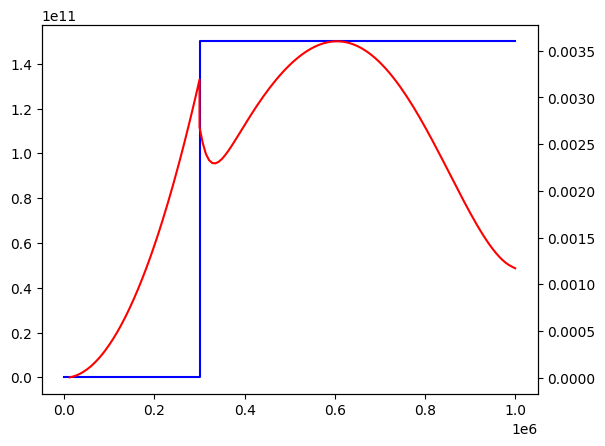

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(result.radius_array, result.bulk_modulus_array, c='b')
ax2 = ax.twinx()
ax2.plot(result.radius_array, sen_bulk, c='r')
plt.show()